In [145]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

writer = SummaryWriter('C:/Users/gouwenss/programming/runs/simple_neural_net_experiment')

That works perfectly. So MLE estimated using neural networks are possible. Let's try it with a more complicated model. Tensorflow does not have a gaussian likelihood function implemented natively, so we switch to pytorch.

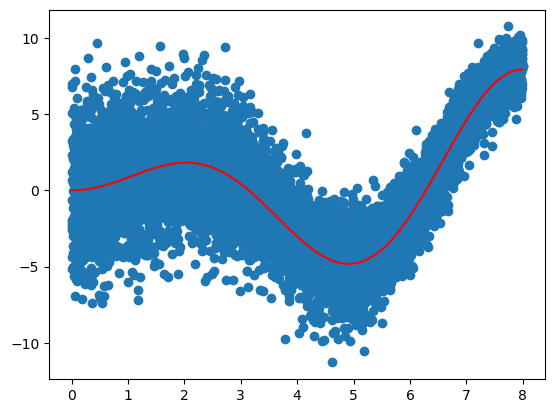

In [146]:
N = 7500 # 2500 part for validation
x = np.random.uniform(0, 8, N)

funMean = lambda x: x*np.sin(x)
funStdev = lambda x: 3 - x/4
y_true_mean = funMean(x)
y_true_stdev = funStdev(x)

y = y_true_mean + np.random.normal(0, y_true_stdev, N)

x = torch.FloatTensor(x).unsqueeze(1) 
y = torch.FloatTensor(y)

x, x_test, y, y_test = train_test_split(x, y, test_size=.3333, random_state=42)

plt.scatter(data["x"], data["y"])
plt.plot(data["x"], data["y_true"], color="red")

In [147]:
import copy

class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(1, 8)
        self.layer2 = nn.Linear(8, 8)
       
        self.nodeMean = nn.Linear(8, 1)
        self.nodeStdev = nn.Linear(8, 1)
        self.softplus = nn.Softplus()
        self.ReLU = nn.ReLU()

    def forward(self, x):
        
        x = self.softplus(self.layer1(x))
        x = self.softplus(self.layer2(x))

        mean = self.nodeMean(x)
        stdev = self.softplus(self.nodeStdev(x))
        
        return mean, stdev

def createModelMLE():
    model = SimpleNeuralNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  
    return model, optimizer

x = torch.FloatTensor(x).unsqueeze(1) 
y = torch.FloatTensor(y)

modelLinear, optimizer = createModelMLE()

# Training the model
best_loss = float('inf')
num_epochs = 20000
patience = 10

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    mean, stdev = modelLinear(x)
    loss = nn.GaussianNLLLoss()(mean.squeeze(), y, stdev.squeeze()**2)
    loss.backward()
    optimizer.step()

    

    # Early stopping 
    if loss < best_loss:
        best_loss = loss
        best_model_weights = copy.deepcopy(modelLinear.state_dict())
        patience = 50
    else: 
        patience -= 1
        if patience == 0:
            break
        
    if (epoch + 1) % 100 == 0:
        
        meanTrain, _ = modelLinear(x)
        mseTrain = torch.mean((meanTrain.squeeze() - y) ** 2)
        meanTest, _ = modelLinear(x_test)
        mseTest = torch.mean((meanTest.squeeze() - y_test) ** 2)
        writer.add_scalar('C:/Users/gouwenss/programming/Loss/train', loss.item(), epoch)
        writer.add_scalar('C:/Users/gouwenss/programming/MSE/train', mseTrain.item(), epoch)
        writer.add_scalar('C:/Users/gouwenss/programming/MSE/test', mseTest.item(), epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, In-sample Error: {mseTrain.item():.4f}, Out-of-sample Error: {mseTest.item():.4f}")

Epoch [100/20000], Loss: 1.9523, In-sample Error: 15.6130, Out-of-sample Error: 15.2031
Epoch [200/20000], Loss: 1.8344, In-sample Error: 15.6487, Out-of-sample Error: 15.2377
Epoch [300/20000], Loss: 1.8208, In-sample Error: 15.7106, Out-of-sample Error: 15.2983
Epoch [400/20000], Loss: 1.8173, In-sample Error: 15.7714, Out-of-sample Error: 15.3582
Epoch [500/20000], Loss: 1.8150, In-sample Error: 15.8171, Out-of-sample Error: 15.4039
Epoch [600/20000], Loss: 1.8131, In-sample Error: 15.8370, Out-of-sample Error: 15.4251
Epoch [700/20000], Loss: 1.8111, In-sample Error: 15.8250, Out-of-sample Error: 15.4163
Epoch [800/20000], Loss: 1.8088, In-sample Error: 15.7763, Out-of-sample Error: 15.3732
Epoch [900/20000], Loss: 1.8057, In-sample Error: 15.6834, Out-of-sample Error: 15.2891
Epoch [1000/20000], Loss: 1.8015, In-sample Error: 15.5316, Out-of-sample Error: 15.1507
Epoch [1100/20000], Loss: 1.7953, In-sample Error: 15.2911, Out-of-sample Error: 14.9307
Epoch [1200/20000], Loss: 1.78

KeyboardInterrupt: 

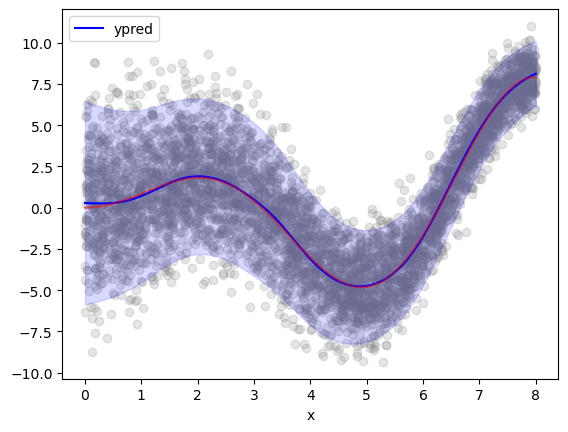

In [148]:
x_list = x.detach().cpu().numpy().flatten()
mean_list = mean.detach().cpu().numpy().flatten()
stdev_list = stdev.detach().cpu().numpy().flatten()

df = pd.DataFrame({"x": x_list, "y": y, "ypred": mean_list, "stdev": stdev_list,
                   "predIntervalUpper": mean_list + 1.96*stdev_list,
                   "predIntervalLower": mean_list - 1.96*stdev_list,
                   })
df = df.sort_values("x")

ax = df.plot(x="x", y=["ypred"], color="blue")

ax.plot(data["x"], data["y_true"], color="red", alpha=.5)
ax.scatter(df["x"], df["y"], color='grey', label="Data Points", alpha=.2)
ax.fill_between(df["x"], df["predIntervalLower"], df["predIntervalUpper"], 
                color='blue', alpha=0.15, label="Prediction Interval")

What if we try to use XGBoost to solve the MLE in two steps? That is, first solve the mean, and given the mean, use a custom loss function to estimate the variance

In [134]:
import xgboost as xgb

def rolling_average(values, window_size):
    series = pd.Series(values)
    rolling_avg = series.rolling(window=window_size, center=True).mean()
    
    # Filling the NaN values at the start and end
    rolling_avg = rolling_avg.fillna(method='bfill').fillna(method='ffill')
    
    return rolling_avg.values

def gradient_se(y_pred, y_true):
    negLogLikGrad = - 1/y_pred + (y_true-yXgbMean)**2/y_pred**3
    return negLogLikGrad

def hessian_se(y_pred, y_true):
    negLogLikHess = 1/y_pred**2 + 3*(y_true-yXgbMean)**2/y_pred**4
    return negLogLikHess

def custom_se(y_pred, y_true):
    grad = gradient_se(y_pred, y_true)
    hess = hessian_se(y_pred, y_true)
    return grad, hess


xNumpy = x.numpy().reshape(-1, 1)
yNumpy = y.numpy().reshape(-1, 1)

xgbModelMean = xgb.XGBRFRegressor()
xgbModelMean.fit(xNumpy, yNumpy)

yXgbMean = xgbModelMean.predict(xNumpy)
yXgbMean = rolling_average(yXgbMean, 3)

In [139]:
xgbModelSigma = xgb.XGBRFRegressor(objective=custom_se)
xgbModelSigma.fit(xNumpy, yNumpy)

yXgbSigma = xgbModelSigma.predict(xNumpy)
yXgbSigma = rolling_average(yXgbSigma, 3)

yXgbPredLower = yXgbMean - 1.96*yXgbSigma
yXgbPredUpper = yXgbMean + 1.96*yXgbSigma

xgbTable = pd.DataFrame({
    "x": xNumpy.reshape(-1),
    "y": y,
    "yPred": yXgbMean,
    ""
    "yXgbPredLower": yXgbMean - 1.96*yXgbSigma,
    "yXgbPredUpper": yXgbMean + 1.96*yXgbSigma
    })

xgbTable = xgbTable.sort_values("x")

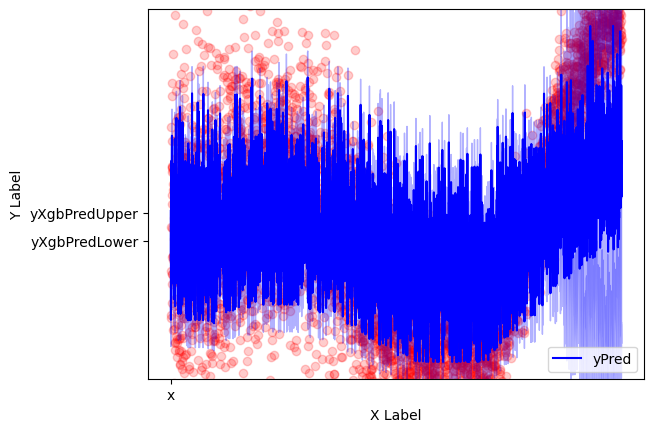

In [136]:
ax = xgbTable.plot(x="x", y="yPred", color="blue")
ax.scatter(xgbTable["x"], xgbTable["y"], color="red", alpha=0.2, label="True Values")

ax.fill_between(xgbTable["x"], xgbTable["yXgbPredLower"], xgbTable["yXgbPredUpper"], 
                color='blue', alpha=0.3, label="Prediction Interval")

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")

ax.fill_between("x", "yXgbPredLower", "yXgbPredUpper", color='blue', alpha=0.3, label="Prediction Interval")

Below, we train a NN where the parameters mu and sigma do not share the network, but rather have their own

In [20]:
from  sklearn.model_selection import train_test_split

x = torch.FloatTensor(x).unsqueeze(1) 
y = torch.FloatTensor(y)

x1, x2, y1, y2 = train_test_split(x, y, test_size=0.5, random_state=42)

class SimpleNeuralNetworkSep(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetworkSep, self).__init__()

        self.layer1Mean = nn.Linear(1, 2)
        self.layer2Mean = nn.Linear(2, 2)
        self.nodeMean = nn.Linear(2, 1)

        self.layer1Stdev = nn.Linear(1, 2)
        self.layer2Stdev = nn.Linear(2, 2)
        self.nodeStdev = nn.Linear(2, 1)

        self.softplus = nn.Softplus()

    def forward(self, x):
        
        xMean = self.softplus(self.layer1Mean(x))
        xMean = self.softplus(self.layer2Mean(xMean))

        xStdev = self.softplus(self.layer1Stdev(x))
        xStdev = self.softplus(self.layer2Stdev(xStdev))
       
        mean = self.nodeMean(xMean)
        stdev = self.softplus(self.nodeStdev(xStdev))
        
        return mean, stdev

def createModelMLE():
    model = SimpleNeuralNetworkSep()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  
    return model, optimizer

modelLinearSep, optimizer = createModelMLE()

num_epochs = 20000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    mean, stdev = modelLinearSep(x1)
    loss = nn.GaussianNLLLoss()(mean.squeeze(), y1, stdev.squeeze()**2)
    loss.backward()
    optimizer.step()
   
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1000/20000], Loss: 1.9962
Epoch [2000/20000], Loss: 1.8411
Epoch [3000/20000], Loss: 1.8134
Epoch [4000/20000], Loss: 1.7646
Epoch [5000/20000], Loss: 1.4329
Epoch [6000/20000], Loss: 1.1964
Epoch [7000/20000], Loss: 1.1866
Epoch [8000/20000], Loss: 1.1841
Epoch [9000/20000], Loss: 1.1756
Epoch [10000/20000], Loss: 1.1698
Epoch [11000/20000], Loss: 1.1672
Epoch [12000/20000], Loss: 1.1648
Epoch [13000/20000], Loss: 1.1615
Epoch [14000/20000], Loss: 1.1573
Epoch [15000/20000], Loss: 1.1539
Epoch [16000/20000], Loss: 1.1523
Epoch [17000/20000], Loss: 1.1517
Epoch [18000/20000], Loss: 1.1515
Epoch [19000/20000], Loss: 1.1514
Epoch [20000/20000], Loss: 1.1513


In [19]:
x_list = x.detach().cpu().numpy().flatten()
mean_list = mean.detach().cpu().numpy().flatten()
stdev_list = stdev.detach().cpu().numpy().flatten()

df = pd.DataFrame({"x": x_list, "y": y, "ypred": mean_list, "stdev": stdev_list,
                   "predIntervalUpper": mean_list + 1.96*stdev_list,
                   "predIntervalLower": mean_list - 1.96*stdev_list,
                   })
df = df.sort_values("x")

ax = df.plot(x="x", y=["ypred"], color="blue")

ax.plot(data["x"], data["y_true"], color="red")
ax.scatter(df["x"], df["y"], color='grey', label="Data Points", alpha=.2)
ax.fill_between(df["x"], df["predIntervalLower"], df["predIntervalUpper"], 
                color='blue', alpha=0.3, label="Prediction Interval")

ValueError: All arrays must be of the same length